# NLP with Python: Knowledge Graph

Taken from [Medium](https://towardsdatascience.com/nlp-with-python-knowledge-graph-12b93146a458)

In [1]:
## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2

## for text
# import wikipediaapi  #0.5.8
import nltk  #3.8.1
import re

## for nlp
import spacy  #3.5.0
from spacy import displacy
import textacy  #0.12.0

## for graph
import networkx as nx  #3.0 (also pygraphviz==1.10)

## for timeline
import dateparser #1.1.7

2023-07-02 20:08:48.354504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 20:08:49.189666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-02 20:08:49.999671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 20:08:50.024699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
with open('../../../data/zelda.txt', 'r') as f:
	txt = f.read()

In [3]:
txt

'Link awakens from a deep slumber and a mysterious voice guides him to discover what has become of the ruined country of Hyrule Kingdom.[9] Link leaves the Shrine of Resurrection, runs up to the ledge ,and looks out at the ruins of the kingdom Hof yrule. Link then meets an Old Man, who will give him the Paraglider, which is the only way to get to Hyrule. The Old Man wants the Spirit Orbs, in the Shrines, respectively the Oman Au Shrine, Ja Baij Shrine, Owa Daim Shrine, and teh Namut Shrine. After Link gets the spirit orbs, the Old Man appears, then mysteriously disappears, telling Link to meet him in the Temple of Time. The Old Man reveals himself as the spirit of the deceased King of Hyrule, King Rhoam. Link learns from King Rhoam that 100 years prior, a great evil known as the Calamity Ganon rose up and laid waste to the kingdom and its people.[10] Unable to be defeated, it was sealed within Hyrule Castle, while the ruins of the land were ravaged by nature over time. Although trapped

In [4]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(txt)

In [5]:
# from text to a list of sentences
lst_docs = [sent for sent in doc.sents]
print("tot sentences:", len(lst_docs))

tot sentences: 19


In [6]:
# take a sentence
i = 3
lst_docs[i]

The Old Man wants the Spirit Orbs, in the Shrines, respectively the Oman Au Shrine, Ja Baij Shrine, Owa Daim Shrine, and teh Namut Shrine.

In [7]:
for token in lst_docs[i]:
    print(token.text, "-->", "pos: "+token.pos_, "|", "dep: "+token.dep_, "")

The --> pos: DET | dep: det 
Old --> pos: PROPN | dep: compound 
Man --> pos: PROPN | dep: nsubj 
wants --> pos: VERB | dep: ROOT 
the --> pos: DET | dep: det 
Spirit --> pos: PROPN | dep: compound 
Orbs --> pos: PROPN | dep: dobj 
, --> pos: PUNCT | dep: punct 
in --> pos: ADP | dep: prep 
the --> pos: DET | dep: det 
Shrines --> pos: PROPN | dep: pobj 
, --> pos: PUNCT | dep: punct 
respectively --> pos: ADV | dep: advmod 
the --> pos: DET | dep: det 
Oman --> pos: PROPN | dep: compound 
Au --> pos: PROPN | dep: compound 
Shrine --> pos: PROPN | dep: appos 
, --> pos: PUNCT | dep: punct 
Ja --> pos: PROPN | dep: compound 
Baij --> pos: PROPN | dep: compound 
Shrine --> pos: PROPN | dep: conj 
, --> pos: PUNCT | dep: punct 
Owa --> pos: PROPN | dep: compound 
Daim --> pos: PROPN | dep: compound 
Shrine --> pos: PROPN | dep: conj 
, --> pos: PUNCT | dep: punct 
and --> pos: CCONJ | dep: cc 
teh --> pos: NOUN | dep: compound 
Namut --> pos: PROPN | dep: compound 
Shrine --> pos: PROPN |

In [8]:
from spacy import displacy

displacy.render(lst_docs[i], style="dep", options={"distance":100})

In [9]:
displacy.render(lst_docs[i], style="ent")

In [10]:
def extract_entities(doc):
    a, b, prev_dep, prev_txt, prefix, modifier = "", "", "", "", "", ""
    for token in doc:
        if token.dep_ != "punct":
            ## prexif --> prev_compound + compound
            if token.dep_ == "compound":
                prefix = prev_txt +" "+ token.text if prev_dep == "compound" else token.text
            
            ## modifier --> prev_compound + %mod
            if token.dep_.endswith("mod") == True:
                modifier = prev_txt +" "+ token.text if prev_dep == "compound" else token.text
            
            ## subject --> modifier + prefix + %subj
            if token.dep_.find("subj") == True:
                a = modifier +" "+ prefix + " "+ token.text
                prefix, modifier, prev_dep, prev_txt = "", "", "", ""
            
            ## if object --> modifier + prefix + %obj
            if token.dep_.find("obj") == True:
                b = modifier +" "+ prefix +" "+ token.text
            
            prev_dep, prev_txt = token.dep_, token.text
    
    # clean
    a = " ".join([i for i in a.split()])
    b = " ".join([i for i in b.split()])
    return (a.strip(), b.strip())


# The relation extraction requires the rule-based matching tool, 
# an improved version of regular expressions on raw text.
def extract_relation(doc, nlp):
    matcher = spacy.matcher.Matcher(nlp.vocab)
    p1 = [{'DEP':'ROOT'}, 
          {'DEP':'prep', 'OP':"?"},
          {'DEP':'agent', 'OP':"?"},
          {'POS':'ADJ', 'OP':"?"}] 
    matcher.add(key="matching_1", patterns=[p1]) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return span.text

In [11]:
## extract entities
lst_entities = [extract_entities(i) for i in lst_docs]

## example
lst_entities[i]

('Old Man', 'Spirit Shrines')

In [12]:
## extract relations
lst_relations = [extract_relation(i,nlp) for i in lst_docs]

## example
lst_relations[i]

'wants'

In [13]:
## extract attributes (NER)
lst_attr = []
for x in lst_docs:
    attr = ""
    for tag in x.ents:
        attr = attr+tag.text if tag.label_=="DATE" else attr+""
    lst_attr.append(attr)

## example
lst_attr[i]

''

In [14]:
## extract entities and relations
dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}

for n,sentence in enumerate(lst_docs):
    lst_generators = list(textacy.extract.subject_verb_object_triples(sentence))  
    for sent in lst_generators:
        subj = "_".join(map(str, sent.subject))
        obj  = "_".join(map(str, sent.object))
        relation = "_".join(map(str, sent.verb))
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic["entity"].append(subj)
        dic["object"].append(obj)
        dic["relation"].append(relation)


## create dataframe
dtf = pd.DataFrame(dic)

## example
dtf[dtf["id"]==i]

,id,text,entity,relation,object
4,3,"The Old Man wants the Spirit Orbs, in the Shri...",Old_Man,wants,Spirit_Orbs


/home/manish/anaconda3/envs/thesis/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


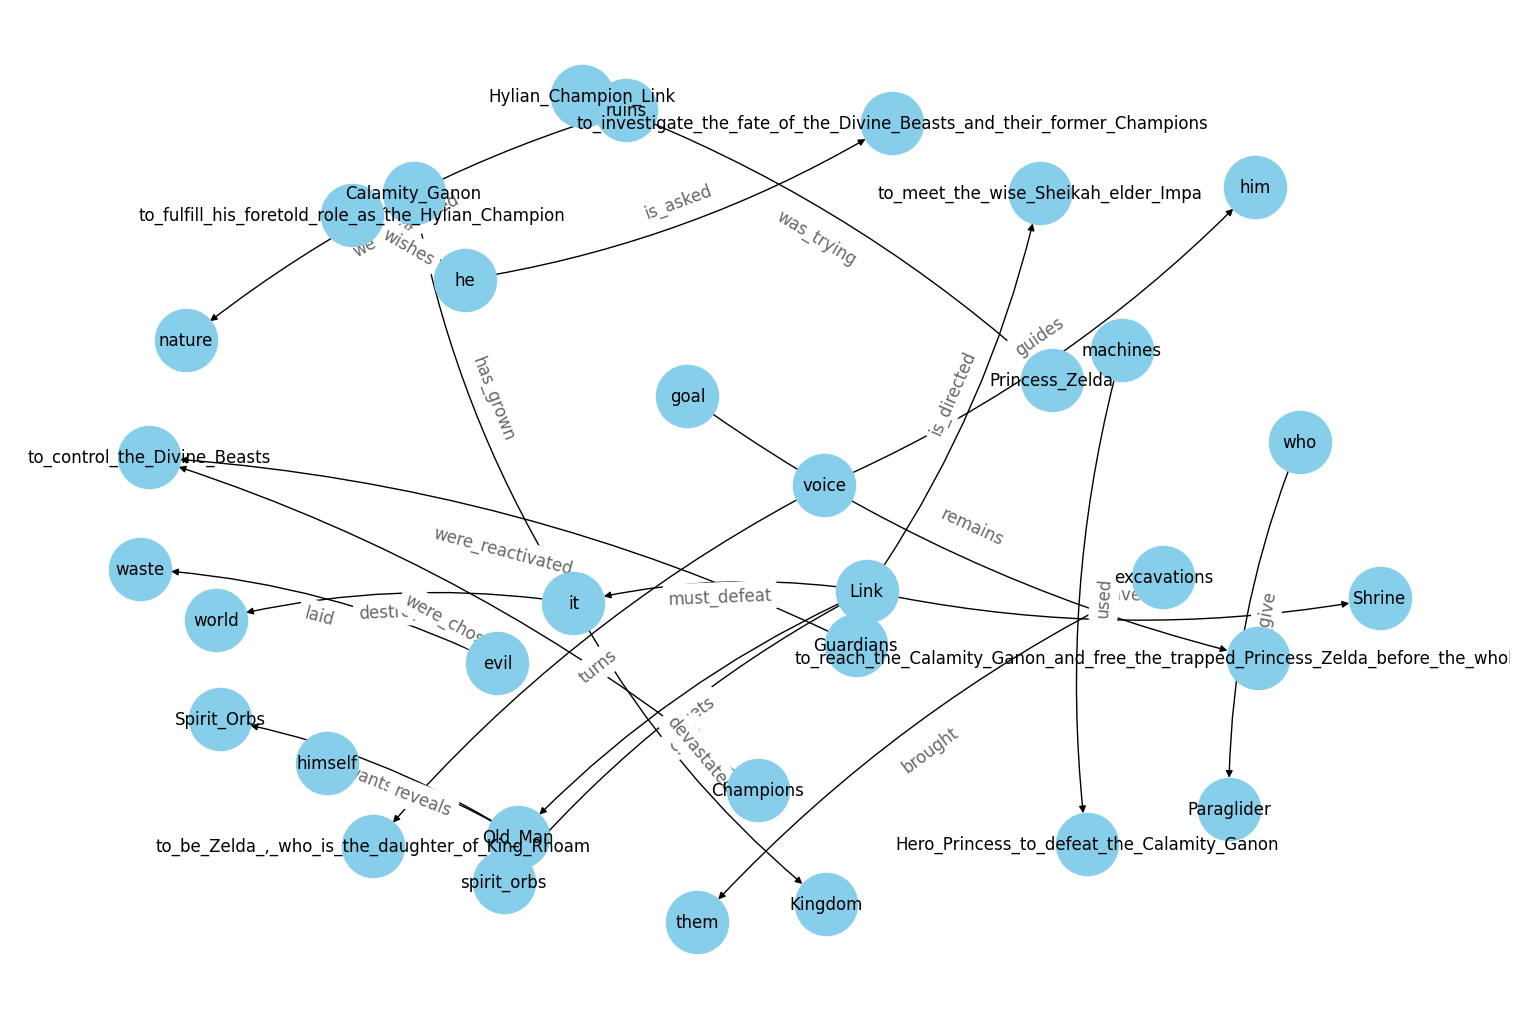

In [15]:
## create full graph
G = nx.from_pandas_edgelist(dtf, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())


## plot
plt.figure(figsize=(15,10))

pos = nx.spring_layout(G, k=1)
node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
        edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                         edge_labels=nx.get_edge_attributes(G,'relation'),
                         font_size=12, font_color='black', alpha=0.6)
plt.show()

/home/manish/anaconda3/envs/thesis/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


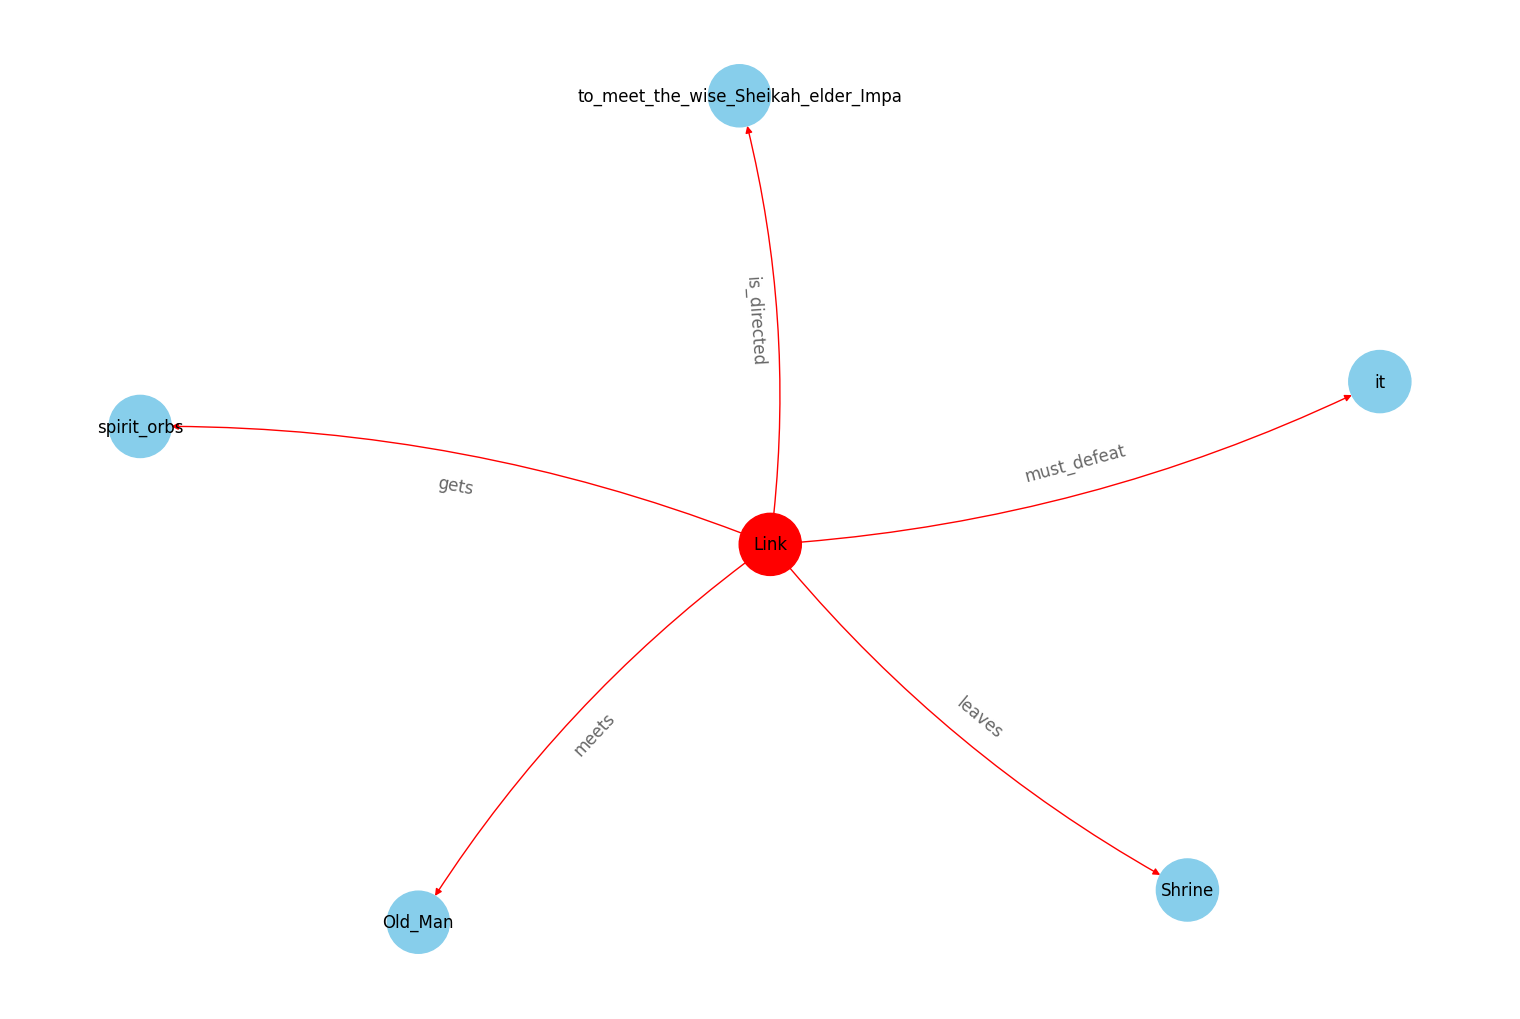

In [19]:
## filter
f = "Link"
tmp = dtf[(dtf["entity"]==f) | (dtf["object"]==f)]


## create small graph
G = nx.from_pandas_edgelist(tmp, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())


## plot
plt.figure(figsize=(15,10))

pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
node_color = ["red" if node==f else "skyblue" for node in G.nodes]
edge_color = ["red" if edge[0]==f else "black" for edge in G.edges]

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
        edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, node_shape="o", connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                        edge_labels=nx.get_edge_attributes(G,'relation'),
                        font_size=12, font_color='black', alpha=0.6)
plt.show()